In [2]:
#all_slow

# Clean

> Functions to split the raw EHR dataset, clean and save for further processing & vocab creation.

In [1]:
#hide
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [2]:
#hide
%reload_ext autoreload
%autoreload 2

In [3]:
#export
from lemonpie.basics import *
from lemonpie.preprocessing import clean
from fastai.imports import *
import ray

In [4]:
#hide
from nbdev.showdoc import *

In [5]:
ray.init()

2022-09-21 17:52:59,899	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.86.91',
 'raylet_ip_address': '192.168.86.91',
 'redis_address': '192.168.86.91:6379',
 'object_store_address': '/tmp/ray/session_2022-09-21_17-52-58_420693_33548/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-09-21_17-52-58_420693_33548/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2022-09-21_17-52-58_420693_33548',
 'metrics_export_port': 58265,
 'node_id': '2f0565a5901d2084b7265164511dda1760ce8de776b2ff70a1d31e4a'}

In [6]:
COHERENT_DATA_STORE = '/home/vinod/code/datasets/coherent'
COHERENT_DATAGEN_DATE = '08-10-2021'
COHERENT_CONDITIONS = {
    "heart_failure" : "88805009",
    "coronary_heart" : "53741008",
    "myocardial_infarction" : "22298006",
    "stroke" : "230690007",
    "cardiac_arrest" : "410429000"
}

# Coherent Preprocessing

**Retain only patients with FHIR bundles.**

In [82]:
def retain_fhir_patients(coherent_path, csv_names):
    """Retain only patients with FHIR bundles."""

    # read pids with FHIR bundles
    file_list = os.listdir(f'{coherent_path}/output/fhir')
    fhir_pids = [((file).split("_")[-1]).split(".")[0] for file in file_list]

    # filter and retain only FHIR patients in all files
    print(f"Writing filtered files to {coherent_path}/raw_original/")
    for file in csv_names:
        old_df = pd.read_csv(f"{coherent_path}/output/csv/{file}.csv", low_memory=False)
        if file == 'patients':
            fhir_mask = old_df.Id.isin(fhir_pids)
        else:
            fhir_mask = old_df.PATIENT.isin(fhir_pids)
        new_df = old_df[fhir_mask]
        assert len(new_df) == fhir_mask.sum(), f"Count error in {file}"
        new_df.to_csv(f"{coherent_path}/raw_original/{file}.csv", index=False)
        print(f"Created {file} with {len(new_df)} records.")
    

**Remove ECG from observations and create ecg.csv**

In [83]:
def moveout_ecg(coherent_path):
    """Move ECG data out of Observations into its own csv."""
    
    old_obs = pd.read_csv(f"{coherent_path}/raw_original/observations.csv", low_memory=False)
    ecg_obs = old_obs[old_obs["CODE"] == "29303009"]
    new_obs = old_obs.drop(ecg_obs.index)
    assert len(new_obs) == len(old_obs) - len(ecg_obs), "Mismatch after ECG removal from Observations"
    new_obs.to_csv(f"{coherent_path}/raw_original/observations.csv", index=False)
    print(f"Updated observations without ECG data = {len(new_obs)} records")

    ecg_obs.reset_index(inplace=True, drop=True)
    odd_indxs = [i for i in range(1, len(ecg_obs), 2)]
    ecg_obs.drop(odd_indxs, inplace=True)
    ecg_obs.drop(columns=["ENCOUNTER", "CODE", "DESCRIPTION", "UNITS", "TYPE"], inplace=True)
    ecg_obs.rename(str.lower, axis='columns', inplace=True)
    ecg_obs.to_csv(f"{coherent_path}/ecg.csv", index=False)
    print(f"Saved ECG data to {coherent_path}/ecg.csv with {len(ecg_obs)} records")

**Create `modalities.csv`**

In [84]:
def create_modalities_csv(coherent_path):
    """Create modalities csv."""
    
    # dna - counts off by 1, because no FHIR bunde for 1 pt with dna data
    dna_files = os.listdir(f'{coherent_path}/output/dna')
    dna_pids = [file.split("_")[-2] for file in dna_files]
    
    # mri
    mri_files = os.listdir(f'{coherent_path}/output/dicom')
    mri_pids = [file.split("_")[-1].split(".")[0][:-1]  for file in mri_files]
    
    # ecg
    ecg_data = pd.read_csv(f"{coherent_path}/ecg.csv")
    ecg_pids = ecg_data.patient.unique()

    # create modalities csv
    patients = pd.read_csv(f"{coherent_path}/raw_original/patients.csv", low_memory=False)
    modalities = patients[["Id", "FIRST", "LAST"]].copy()
    modalities.rename(str.lower, axis='columns', inplace=True)

    modalities["mri"] = patients.Id.isin(mri_pids)
    modalities["dna"] = patients.Id.isin(dna_pids)
    modalities["ecg"] = patients.Id.isin(ecg_pids)

    modalities.to_csv(f"{coherent_path}/modalities.csv", index=False)
    print(f"Saved modalities to {coherent_path}/modalities.csv")

In [85]:
def coherent_preprocess(coherent_path=COHERENT_DATA_STORE, csv_names=FILENAMES):
    """Perform coherent-specific preprocessing."""

    # create raw_original dir
    raw_dir = Path(f'{coherent_path}/raw_original')
    raw_dir.mkdir(parents=True, exist_ok=True)

    # filter patients to keep only those with FHIR bundles
    print("--Filtering & retaining patients with FHIR bundles--")
    retain_fhir_patients(coherent_path, csv_names)

    # move ECG data out of observations
    print("--Moving ECG data out of observations into its own ecg.csv--")
    moveout_ecg(coherent_path)

    # create modalities file
    print("--Creating modalities.csv--")
    create_modalities_csv(coherent_path)

In [86]:
coherent_preprocess()

--Filtering & retaining patients with FHIR bundles--
Writing filtered files to /home/vinod/code/datasets/coherent/raw_original/
Created patients with 1278 records.
Created observations with 705436 records.
Created allergies with 106 records.
Created careplans with 6135 records.
Created medications with 209401 records.
Created imaging_studies with 3752 records.
Created procedures with 56092 records.
Created conditions with 15956 records.
Created immunizations with 11900 records.
--Moving ECG data out of observations into its own ecg.csv--
Updated observations without ECG data = 703292 records
Saved ECG data to /home/vinod/code/datasets/coherent/ecg.csv with 1072 records
--Creating modalities.csv--
Saved modalities to /home/vinod/code/datasets/coherent/modalities.csv


In [87]:
clean.clean_raw_ehrdata(COHERENT_DATA_STORE, 0.2, 0.2, COHERENT_CONDITIONS, COHERENT_DATAGEN_DATE)

Splits:: train: 0.6, valid: 0.2, test: 0.2
Split patients into:: Train: 766, Valid: 256, Test: 256 -- Total before split: 1278
Saved train data to /home/vinod/code/datasets/coherent/raw_split/train
Saved valid data to /home/vinod/code/datasets/coherent/raw_split/valid
Saved test data to /home/vinod/code/datasets/coherent/raw_split/test
Completed - test
Completed - valid
(pid=11052) Saved cleaned "valid" data to /home/vinod/code/datasets/coherent/cleaned/valid
(pid=11055) Saved cleaned "test" data to /home/vinod/code/datasets/coherent/cleaned/test
(pid=11035) Saved cleaned "train" data to /home/vinod/code/datasets/coherent/cleaned/train
Completed - train


(pid=11035) Saved vocab code tables to /home/vinod/code/datasets/coherent/cleaned/train/codes


# Tests 

In [9]:
train_dfs, valid_dfs, test_dfs = clean.load_cleaned_ehrdata(COHERENT_DATA_STORE)
code_dfs = clean.load_ehr_vocabcodes(COHERENT_DATA_STORE)

In [10]:
# for df in train_dfs:
#     display(df.head())

In [11]:
thispt = train_dfs[0].iloc[10]

In [12]:
thispt

patient                      967d5226-f8c4-60a8-b882-6ef803af88a6
birthdate                                              1930-04-29
heart_failure                                               False
heart_failure_age                                             NaN
coronary_heart                                              False
coronary_heart_age                                            NaN
myocardial_infarction                                       False
myocardial_infarction_age                                     NaN
stroke                                                       True
stroke_age                                                   87.0
cardiac_arrest                                              False
cardiac_arrest_age                                            NaN
Name: 10, dtype: object

In [13]:
# for df in code_dfs:
#     display(df.head())

Making sure condition counts match - after extracting `y` for each patient

`patients` dfs after cleaning, with `y` extracted

In [14]:
pts_train, pts_valid, pts_test = train_dfs[0], valid_dfs[0], test_dfs[0]

`conditions` dfs

In [15]:
cnd_train, cnd_valid, cnd_test = train_dfs[8], valid_dfs[8], test_dfs[8]

Tests to ensure counts match

In [16]:
def test_extract_ys(pt_dfs, cnd_dfs, conditions_dict=COHERENT_CONDITIONS):
    """Test for extract_ys function."""
    for pts_df, cnds_df, split in zip(pt_dfs, cnd_dfs, ['train','valid','test']):
        print(f"Checking {split} dfs...")
        for this_cnd in conditions_dict.keys():
            code = f"{conditions_dict[this_cnd]}||START"
            cnds_df_counts = len(cnds_df[cnds_df['code'] == code])
            pts_df_counts = len(pts_df[pts_df[this_cnd] == 1])
            assert cnds_df_counts == pts_df_counts, f"Error in {split} for {this_cnd} -- {cnds_df_counts} != {pts_df_counts}"

        print(f"Tests passed for {split} - all condition counts match")
    return

In [17]:
test_extract_ys([pts_train, pts_valid, pts_test],[cnd_train, cnd_valid, cnd_test])

Checking train dfs...
Tests passed for train - all condition counts match
Checking valid dfs...
Tests passed for valid - all condition counts match
Checking test dfs...
Tests passed for test - all condition counts match


In [18]:
clean.get_label_counts([pts_train, pts_valid, pts_test], conditions_dict=COHERENT_CONDITIONS)

[{'heart_failure': 189,
  'coronary_heart': 194,
  'myocardial_infarction': 82,
  'stroke': 435,
  'cardiac_arrest': 107},
 {'heart_failure': 68,
  'coronary_heart': 66,
  'myocardial_infarction': 28,
  'stroke': 138,
  'cardiac_arrest': 30},
 {'heart_failure': 75,
  'coronary_heart': 76,
  'myocardial_infarction': 35,
  'stroke': 125,
  'cardiac_arrest': 43}]

# Small run through lemonpie

Steps as detailed here - https://corazonlabs.github.io/lemonpie/quick_walkthru

In [7]:
labels = ['heart_failure', 'coronary_heart', 'myocardial_infarction', 'stroke', 'cardiac_arrest']

In [8]:
from lemonpie.preprocessing import transform

In [9]:
transform.preprocess_ehr_dataset(
    COHERENT_DATA_STORE, 
    COHERENT_DATAGEN_DATE, 
    conditions_dict=COHERENT_CONDITIONS, 
    age_start=20, 
    age_stop=40, 
    age_in_months=False,
    from_raw_data=True)

------------------- Splitting and cleaning raw dataset -------------------
Splits:: train: 0.6, valid: 0.2, test: 0.2
Split patients into:: Train: 766, Valid: 256, Test: 256 -- Total before split: 1278
Saved train data to /home/vinod/code/datasets/coherent/raw_split/train
Saved valid data to /home/vinod/code/datasets/coherent/raw_split/valid
Saved test data to /home/vinod/code/datasets/coherent/raw_split/test
Completed - valid
(pid=33751) Saved cleaned "valid" data to /home/vinod/code/datasets/coherent/cleaned/valid
Completed - test
(pid=33745) Saved cleaned "test" data to /home/vinod/code/datasets/coherent/cleaned/test
(pid=33754) Saved cleaned "train" data to /home/vinod/code/datasets/coherent/cleaned/train
(pid=33754) Saved vocab code tables to /home/vinod/code/datasets/coherent/cleaned/train/codes
Completed - train
------------------- Creating vocab lists -------------------
Saved vocab lists to /home/vinod/code/datasets/coherent/processed
------------------- Creating patient lists

In [10]:
from lemonpie import data

In [11]:
coherent_data = data.EHRData(COHERENT_DATA_STORE, labels, age_start=20, age_stop=40, age_in_months=False, lazy_load_gpu=False)

In [12]:
from lemonpie.preprocessing import vocab

In [38]:
demograph_dims, rec_dims, demograph_dims_wd, rec_dims_wd = vocab.get_all_emb_dims(vocab.EhrVocabList.load(COHERENT_DATA_STORE))
train_dl, valid_dl, train_pos_wts, valid_pos_wts = coherent_data.get_data(bs=64)

In [39]:
len(train_dl), len(valid_dl)

(12, 2)

In [40]:
from lemonpie import learn

In [41]:
train_loss_fn, valid_loss_fn = learn.get_loss_fn(train_pos_wts), learn.get_loss_fn(valid_pos_wts)

#### `EHR_LSTM`

In [42]:
from lemonpie import models

In [43]:
model = models.EHR_LSTM(demograph_dims, rec_dims, demograph_dims_wd, rec_dims_wd, num_labels=len(labels)).to(DEVICE)
optimizer = torch.optim.Adagrad(model.parameters())

In [44]:
model

EHR_LSTM(
  (embs): ModuleList(
    (0): Embedding(40, 8)
    (1): Embedding(16, 8)
    (2): Embedding(128, 8)
    (3): Embedding(8, 8)
    (4): Embedding(8, 8)
    (5): Embedding(8, 8)
    (6): Embedding(8, 8)
    (7): Embedding(264, 16)
    (8): Embedding(192, 16)
    (9): Embedding(8, 8)
    (10): Embedding(184, 16)
  )
  (embgs): ModuleList(
    (0): EmbeddingBag(664, 16, mode=mean)
    (1): EmbeddingBag(16, 8, mode=mean)
    (2): EmbeddingBag(56, 8, mode=mean)
    (3): EmbeddingBag(240, 16, mode=mean)
    (4): EmbeddingBag(16, 8, mode=mean)
    (5): EmbeddingBag(144, 8, mode=mean)
    (6): EmbeddingBag(192, 16, mode=mean)
    (7): EmbeddingBag(16, 8, mode=mean)
  )
  (input_dp): InputDropout()
  (lstm): LSTM(88, 88, num_layers=4, batch_first=True, dropout=0.3)
  (lin): Sequential(
    (0): Linear(in_features=208, out_features=416, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=416, out_features=832, bias=True)
    (4): ReL

In [45]:
history = learn.RunHistory(labels)

In [46]:
from lemonpie import metrics

`use_amp=False`

In [47]:
history = learn.fit(5, history, model, train_loss_fn, valid_loss_fn, optimizer, metrics.auroc_score, \
              train_dl, valid_dl, to_chkpt_path=None, from_chkpt_path=None, verbosity=1, use_amp=False)

epoch |     train loss |     train aurocs                  valid loss |     valid aurocs    
----------------------------------------------------------------------------------------------------
    0 |          6.024 | [0.485 0.467 0.486 0.515]              1.044 | [0.474 0.513 0.534 0.635]
    1 |          1.020 | [0.528 0.561 0.566 0.580]              1.023 | [0.500 0.578 0.623 0.652]
    2 |          1.002 | [0.577 0.613 0.634 0.592]              1.079 | [0.521 0.560 0.565 0.633]
    3 |          0.985 | [0.516 0.636 0.669 0.564]              1.044 | [0.502 0.590 0.646 0.599]
    4 |          0.954 | [0.568 0.621 0.744 0.590]              1.062 | [0.527 0.593 0.656 0.608]


`use_amp=True`

In [48]:
history = learn.fit(5, history, model, train_loss_fn, valid_loss_fn, optimizer, metrics.auroc_score, \
              train_dl, valid_dl, to_chkpt_path=MODEL_STORE, from_chkpt_path=None, verbosity=1, use_amp=True)

epoch |     train loss |     train aurocs                  valid loss |     valid aurocs    
----------------------------------------------------------------------------------------------------
    0 |          0.914 | [0.645 0.681 0.803 0.597]              1.033 | [0.520 0.576 0.637 0.630]
    1 |          0.863 | [0.681 0.714 0.852 0.605]              1.097 | [0.530 0.579 0.660 0.613]
    2 |          0.812 | [0.705 0.711 0.897 0.645]              1.104 | [0.536 0.579 0.658 0.615]
    3 |          0.791 | [0.675 0.774 0.911 0.661]              1.201 | [0.532 0.567 0.651 0.585]
    4 |          0.759 | [0.752 0.760 0.921 0.657]              1.224 | [0.542 0.565 0.642 0.565]
Checkpointed to "/home/vinod/.lemonpie/models/checkpoint.tar"


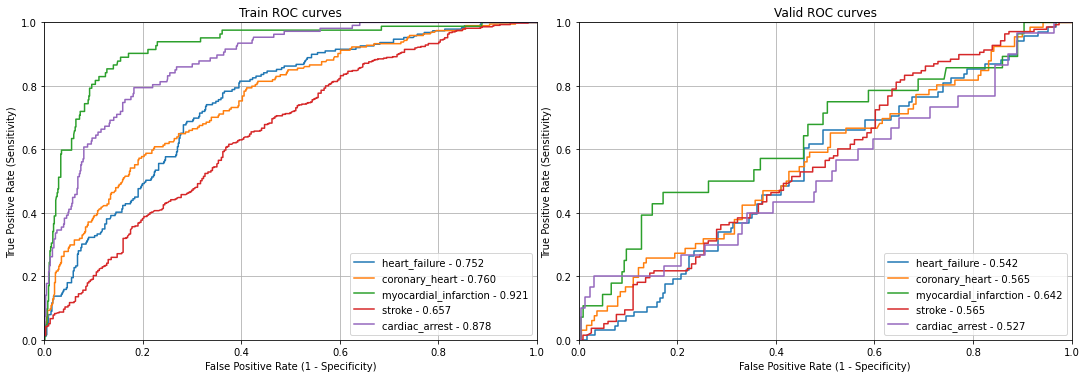

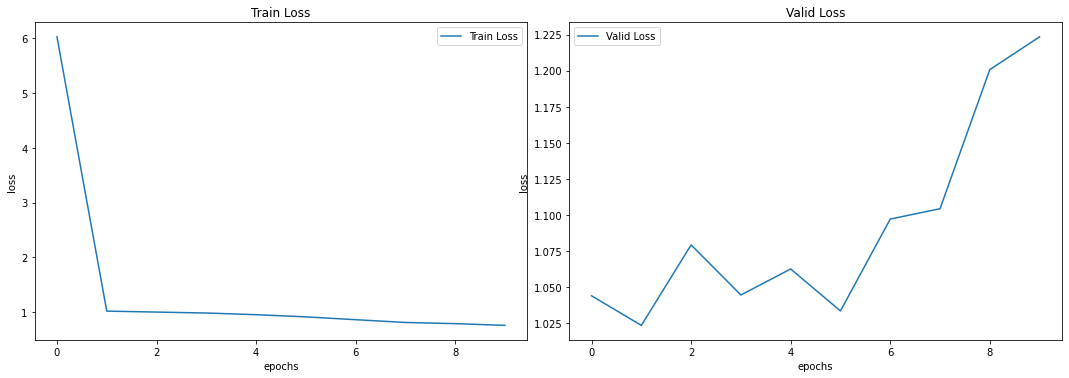

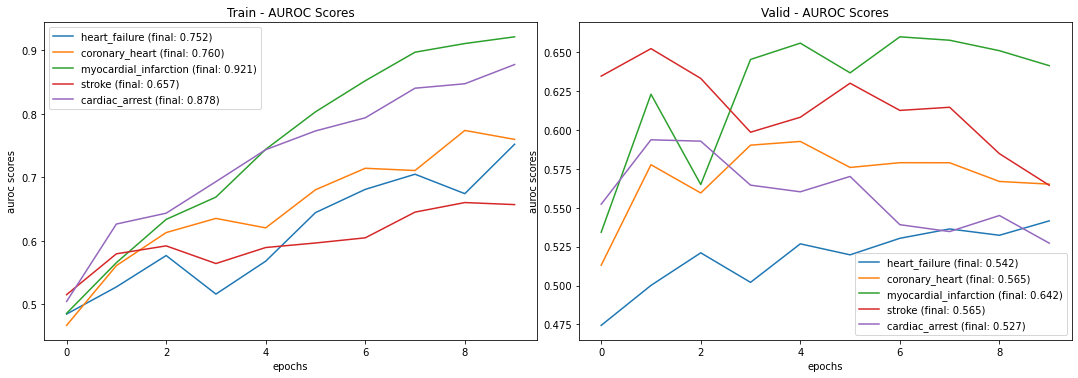

In [49]:
learn.plot_fit_results(history, labels)

In [50]:
test_dl, test_pos_wts = coherent_data.get_test_data()
len(test_dl)

2

In [51]:
test_loss_fn =learn.get_loss_fn(test_pos_wts)

In [52]:
history = learn.predict(history, model, test_loss_fn, metrics.auroc_score, test_dl, chkpt_path=MODEL_STORE)

From "/home/vinod/.lemonpie/models/checkpoint.tar", loading model ...
test loss = 1.203669548034668
test aurocs = [0.500847 0.538487 0.534131 0.582198 0.627361]



Prediction Summary ...
                       auroc_score  optimal_threshold     auroc_95_ci
heart_failure             0.500847          -0.211304  (0.425, 0.576)
coronary_heart            0.538487          -0.263672  (0.459, 0.617)
myocardial_infarction     0.534131          -1.263672  (0.426, 0.642)
stroke                    0.582198           0.244629  (0.516, 0.652)
cardiac_arrest            0.627361           0.106445  (0.522, 0.723)


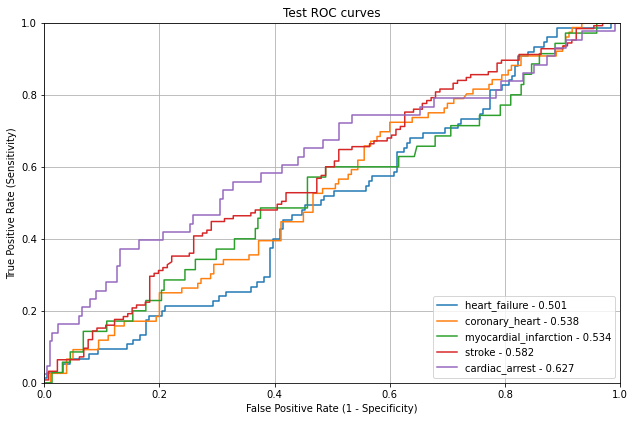

In [53]:
history = learn.summarize_prediction(history, labels)

# MRI

In [22]:
img = pd.read_csv(f"{COHERENT_DATA_STORE}/output/csv/imaging_studies.csv")
cnd = pd.read_csv(f"{COHERENT_DATA_STORE}/output/csv/conditions.csv")
mri_encs = img[img.MODALITY_CODE == "MR"].ENCOUNTER
#smh = Silent micro-hemorrhage
smh = cnd[cnd.ENCOUNTER.isin(mri_encs)].CODE == 723857007
assert smh.sum() == len(mri_encs)
smh.sum(), len(mri_encs)

(331, 331)